In [2]:
!pip install neural-tangents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 10.3 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import numpy as np
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
from tqdm import tqdm

# Phase 2: Compare the empirical NTK of a finite network to its analytical (infinite-width) counterpart.


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 623kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.88MB/s]
Training Epochs: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


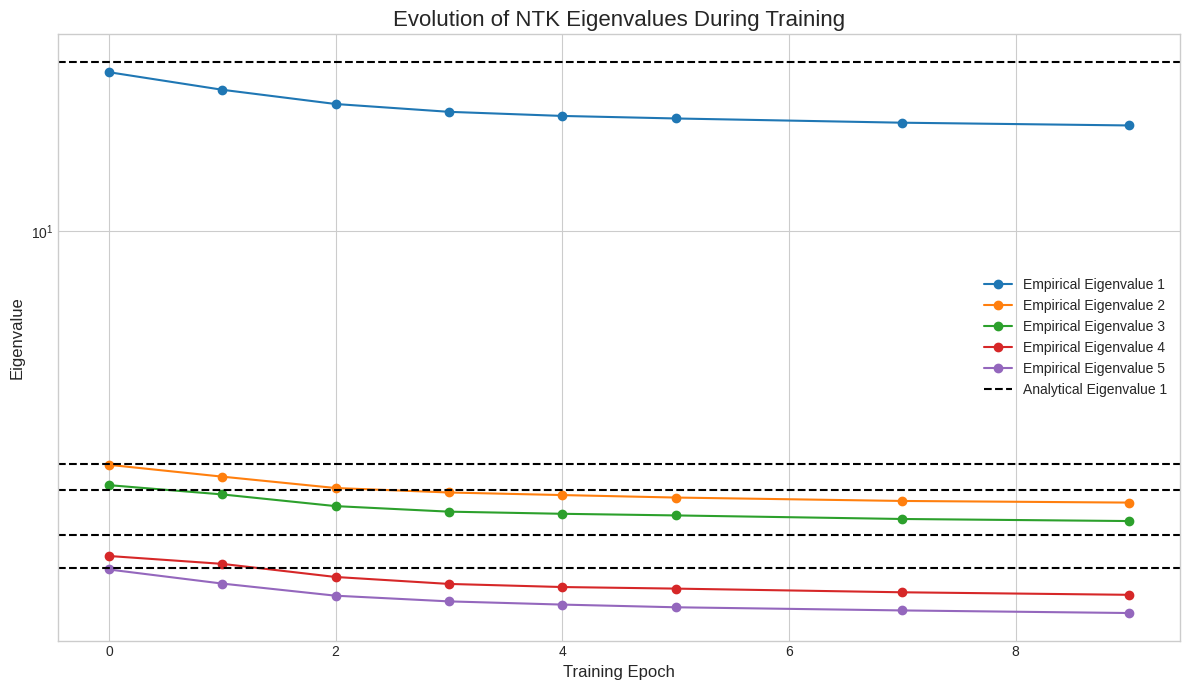

In [4]:
# Network
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(10)
)

# A small test subset (N=100) as NTK computation is O(N^2)
BATCH_SIZE = 128
TEST_SUBSET_SIZE = 100
TRAIN_SUBSET_SIZE = 1000

train_dataset = torchvision.datasets.MNIST(
    './data', train=True, download=True,
    transform=torchvision.transforms.Compose([
       torchvision.transforms.ToTensor(),
       torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_dataset = torchvision.datasets.MNIST(
    './data', train=False,
    transform=torchvision.transforms.Compose([
       torchvision.transforms.ToTensor(),
       torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(TRAIN_SUBSET_SIZE)),
    batch_size=BATCH_SIZE, shuffle=True)

test_subset = torch.utils.data.Subset(test_dataset, range(TEST_SUBSET_SIZE))
x_test = jnp.array(np.array([data[0].numpy() for data in test_subset])).reshape(TEST_SUBSET_SIZE, -1)
y_test = jnp.array(np.array([data[1] for data in test_subset]))

# The static and theoretical NTK for the infinite-width network
ntk_analytic = kernel_fn(x_test, x_test, 'ntk')

key = jax.random.PRNGKey(0)
_, params = init_fn(key, (-1, 28 * 28))

NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
opt_init, opt_update, get_params = optimizers.adam(LEARNING_RATE)
opt_state = opt_init(params)
TRACK_EPOCHS = [0, 1, 2, 3, 4, 5, 7, 9]

def loss(params, x, y):
    y_one_hot = jax.nn.one_hot(y, 10)
    return 0.5 * jnp.mean((apply_fn(params, x) - y_one_hot)**2)

grad_loss = jax.jit(jax.grad(loss))

empirical_ntk_history = []
empirical_kernel_fn = nt.empirical_kernel_fn(apply_fn)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Epochs"):
    if epoch in TRACK_EPOCHS:
        current_params = get_params(opt_state)
        ntk_current = empirical_kernel_fn(x_test, x_test, get='ntk', params=current_params)
        empirical_ntk_history.append(ntk_current)

    for x_batch, y_batch in train_loader:
        x_batch_jnp = jnp.array(x_batch.numpy().reshape(x_batch.shape[0], -1))
        y_batch_jnp = jnp.array(y_batch.numpy())
        current_params = get_params(opt_state)
        grads = grad_loss(current_params, x_batch_jnp, y_batch_jnp)
        opt_state = opt_update(epoch, grads, opt_state)

# The evolution of the top K eigenvalues on a log-scale plot
K = 5
eigvals_analytic = np.linalg.eigh(ntk_analytic)[0][::-1]
top_k_analytic = eigvals_analytic[:K]

top_k_empirical_history = []
for ntk_matrix in empirical_ntk_history:
    eigvals_empirical = np.linalg.eigh(ntk_matrix)[0][::-1]
    top_k_empirical_history.append(eigvals_empirical[:K])

top_k_empirical_history = np.array(top_k_empirical_history)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

for i in range(K):
    ax.plot(TRACK_EPOCHS, top_k_empirical_history[:, i], marker='o', linestyle='-',
            label=f'Empirical Eigenvalue {i+1}')

for i in range(K):
    ax.axhline(y=top_k_analytic[i], color='k', linestyle='--',
               label=f'Analytical Eigenvalue {i+1}' if i == 0 else "_nolegend_")

ax.set_title("Evolution of NTK Eigenvalues During Training", fontsize=16)
ax.set_xlabel("Training Epoch", fontsize=12)
ax.set_ylabel("Eigenvalue", fontsize=12)
ax.set_yscale('log')
ax.legend()
plt.tight_layout()
plt.show()